In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 2 parameters

$$ y' = \beta exp(-\beta t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 2

data = make_test_data_2()
#Times to evaluate the solution
times = data['t']

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_2, 
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

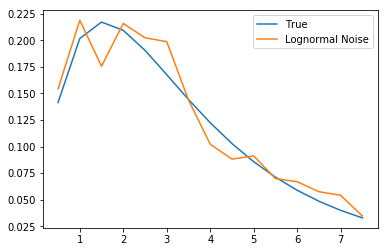

In [3]:
Ytrue = data['y']
Y = data['yobs']

plt.plot(times,Ytrue, label = 'True')
plt.plot(times,Y, label = 'Lognormal Noise')
plt.legend()


In [5]:

    
# my_ODEop = ODEop(ode_model)


In [7]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha', 1)
    beta = pm.HalfNormal('beta', 1)

    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    #[ODE Parameters, initial condition]
    all_params = pm.math.stack([beta,alpha,0],axis=0)

    
    ode_sol = ode_model(all_params)

    
    forward = ode_sol.reshape(Y.shape)

    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [04:35<00:00, 16.11draws/s]


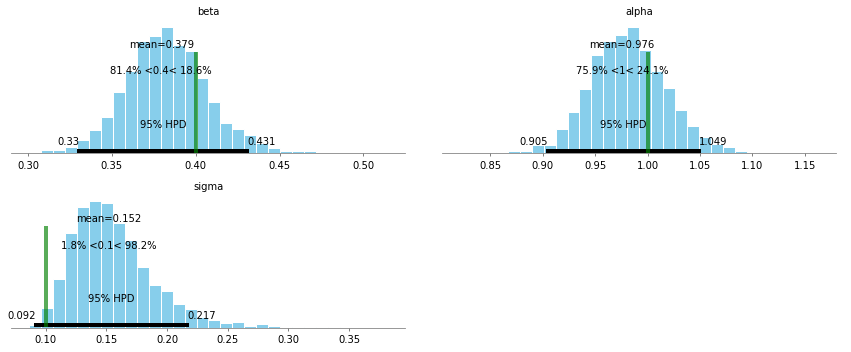

In [8]:
beta = data['p'][0]
alpha = data['p'][1]
sigma = data['sigma']


pm.posteriorplot.plot_posterior(trace,varnames = ['beta', 'alpha', 'sigma'], ref_val = [beta, alpha, sigma]);

In [11]:

pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.975681,0.037115,0.000734,0.904815,1.049095,2685.918924,0.999948
beta,0.379449,0.025164,0.000507,0.330489,0.430755,2318.728761,1.000053
sigma,0.151644,0.034856,0.000755,0.091820,0.216518,2063.284154,0.999757
ode__0,0.135691,0.008699,0.000180,0.119241,0.153817,2216.084416,0.999952
ode__1,0.195537,0.012071,0.000255,0.173315,0.221041,2147.136347,0.999868
ode__2,0.212886,0.012583,0.000270,0.189520,0.239122,2113.685703,0.999803
ode__3,0.207500,0.011671,0.000252,0.184326,0.230071,2115.928518,0.999762
ode__4,0.190931,0.010168,0.000219,0.170935,0.210513,2160.871199,0.999750
ode__5,0.169789,0.008547,0.000181,0.153767,0.186896,2266.710067,0.999778
ode__6,0.147737,0.007065,0.000146,0.134182,0.161470,2466.898008,0.999857


In [12]:
with first_model:
    ppc = pm.sample_ppc(trace, 100)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 100/100 [00:01<00:00, 64.16it/s]


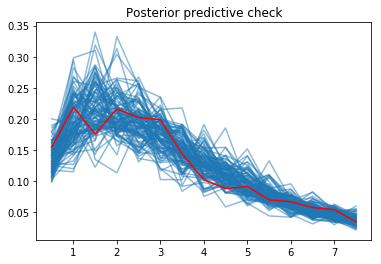

In [13]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,Y, color = 'red')
plt.title('Posterior predictive check');

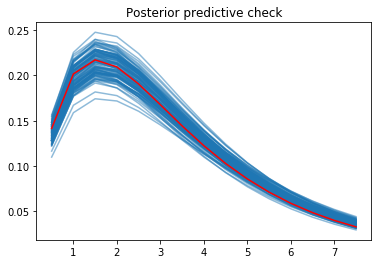

In [14]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i].reshape(Y.shape), color = 'C0', alpha = 0.5)
    
plt.plot(times,Ytrue, color = 'red')
plt.title('Posterior predictive check');